# CROSS-SCALE FLUXES
Following Kaushik et al. 2022


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
client = Client(n_workers=16)
client

distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-tqnxedf_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-zppfx03g', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-o61158jk', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-tdqt5aa0', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-or24hyeq', purging
distributed.diskutils - INFO - Found stale lock file and directory '/data/pacific/jacob/CFB/cfb_on_ebf/notebooks/dask-worker-space/worker-eya0v7gg', purging
distributed.diskutils - INFO - Found stale lock file and d

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39440,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: tcp://127.0.0.1:37043,Total threads: 8
Dashboard: http://127.0.0.1:43020/status,Memory: 31.46 GiB
Nanny: tcp://127.0.0.1:45789,


In [3]:
## LOAD THE NEW RUNS
chunks = {'time':1, 's_rho':1, 'eta_rho':1000, 'eta_v':1000, 'xi_rho':1000, 'xi_u':1000}
chunks = {'time':1, 's_rho':1}

reload(lruns)
#dsWC, gridWC = lruns.loadRun('../data/model/JET_ML_CFB/', chunks={'time':1}, old=False, avg=False)
dsWC, gridWC = lruns.newLoad('../data/model/JET_NML_CFB_BFLUX/', chunks=chunks)

#dsWC['f'] = dsOLD.f

reload(lruns)
# dsNC, gridNC = lruns.loadRun('../data/model/JET_ML_NOCFB/', chunks={'time':1}, old=False, avg=False)
dsNC, gridNC = lruns.newLoad('../data/model/JET_NML_NOCFB_BFLUX/', chunks=chunks)
dsNC

/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/array/core.py:4458: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/homes/metofac/wenegrat/.conda/envs/CFB_EBF_2/lib/python3.10/site-packages/dask/array/core.py:4458: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001, s_rho: 100, s_w: 101, ocean_time: 46, auxil: 4)
Coordinates: (12/26)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float64 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/68)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 1, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1, 4002, 1002), meta=np.ndarray>
Attributes: (12/55)
    type:          ROMS history file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

(0.0, 50.0, 0.0, 50.0)

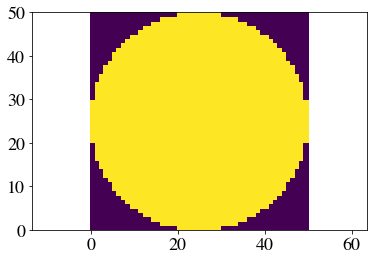

In [41]:
from scipy.signal import convolve2d
from scipy.ndimage import convolve

def filterKernel(filterwidth):
    x = np.arange(0, filterwidth)
    y = np.arange(0, filterwidth)
    filt = np.zeros((x.size, y.size))
    cx = filterwidth/2 -1/2
    cy = filterwidth/2 -1/2
    
    mask = (x[np.newaxis,:]-cx)**2 + (y[:,np.newaxis]-cy)**2 < (filterwidth/2)**2
    filt[mask] = 1
    filt = filt/np.sum(filt)
    return filt
plt.pcolor(filterKernel(50))
plt.axis('equal')

In [42]:
def convFilter(var, filterwidth):
    filt = filterKernel(filterwidth)
    
    #out = convolve2d(var, filt, mode='same')
    out = convolve(var, filt, mode='wrap')
    #print(out.shape)
    return out

def applyFilter(var, filterwidth): 
    # NOTE THIS SHOULD BE CHANGED TO A CIRCULAR FILTER OF SOME SORT
    #out var.rolling(xi_rho = filterwidth, center=True).mean().rolling(eta_rho = filterwidth, center=True).mean()
    
    # Make circular filter
    out = xr.apply_ufunc(
            convFilter, 
            var, # have to rechunk to use with dask
            filterwidth, 
            input_core_dims=[["eta_rho","xi_rho"], []],  # list with one entry per arg
            output_core_dims=[["eta_rho","xi_rho"]],  # returned data has 3 dimension
            #exclude_dims=set(("ocean_time",)),
            vectorize=True,
            dask='parallelized',
            dask_gufunc_kwargs = {'allow_rechunk':True}
            )
    return out
    

#plt.pcolor(applyFilter(0, 40))
#plt.colorbar()

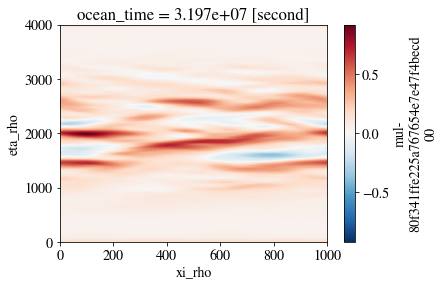

In [12]:
#testing
u_rho = xroms.to_rho(dsWC.u.isel(s_rho=-1), gridWC)
#print(u_rho.chunk({'ocean_time':1, 'xi_rho':1002}))
#u_rho.chunk({'ocean_time':1, 'xi_rho':1002})
    #apply filters
ubar = applyFilter(u_rho, 100)
#dask_gufunc_kwargs.setdefault("allow_rechunk", True)
ubar.isel(ocean_time=10).plot()

In [ ]:
ubar

In [5]:

    
def crossScaleFlux(ds,grid, filterwidth):
    u_rho = xroms.to_rho(ds.u, grid)
    v_rho = xroms.to_rho(ds.v, grid)
    
    #apply filters
    ubar = applyFilter(u_rho, filterwidth)
    vbar = applyFilter(v_rho, filterwidth)
    uubar= applyFilter(u_rho*u_rho, filterwidth)
    uvbar = applyFilter(u_rho*v_rho, filterwidth)
    vvbar = applyFilter(v_rho*v_rho, filterwidth)
    
    #calc gradients
    u_bar_x = xroms.to_rho(grid.derivative(ubar, 'X'), grid)
    u_bar_y = xroms.to_rho(grid.derivative(ubar, 'Y'), grid)
    v_bar_x = xroms.to_rho(grid.derivative(vbar, 'X'), grid)
    v_bar_y = xroms.to_rho(grid.derivative(vbar, 'Y'), grid)

    #form flux terms
    tau_uu = uubar - ubar*ubar
    tau_uv = uvbar - ubar*vbar
    tau_vv = vvbar - vbar*vbar
    
    return -(tau_uu*u_bar_x + tau_uv*(u_bar_y + v_bar_x) + tau_vv*v_bar_y)

def windWork(ds, grid, filterwidth):
    tau_u = xroms.to_rho(ds.sustr, grid)
    tau_v = xroms.to_rho(ds.svstr, grid)
    u_rho = xroms.to_rho(ds.u, grid)
    v_rho = xroms.to_rho(ds.v, grid)
    
    workx_bar = applyFilter(tau_u*u_rho, filterwidth)
    worky_bar = applyFilter(tau_v*v_rho, filterwidth)
    tau_u_bar = applyFilter(tau_u, filterwidth)
    tau_v_bar = applyFilter(tau_v, filterwidth)
    u_bar = applyFilter(u_rho, filterwidth)
    v_bar = applyFilter(v_rho, filterwidth)
    
    return workx_bar - tau_u*u_bar + worky_bar - tau_v*v_bar

In [40]:
PI_WC = crossScaleFlux(dsWC.isel(s_rho=-1),gridWC, 20) # 20 points is 10 km
PI_NC = crossScaleFlux(dsNC.isel(s_rho=-1),gridNC, 20)

PI_WC

<xarray.DataArray (ocean_time: 46, eta_rho: 4002, xi_rho: 1002)>
dask.array<neg, shape=(46, 4002, 1002), dtype=float32, chunksize=(1, 4000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * ocean_time  (ocean_time) float64 3.11e+07 3.119e+07 ... 3.491e+07 3.499e+07
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001

In [ ]:
PI_WC_INT = PI_WC.sum(('eta_rho', 'xi_rho')).compute()

In [ ]:
PI_NC_INT = PI_NC.sum(('eta_rho', 'xi_rho')).compute()

In [ ]:
plt.plot(PI_WC_INT.ocean_time/86400, PI_WC_INT)
plt.plot(PI_NC_INT.ocean_time/86400, PI_NC_INT)

In [6]:
# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
#dsWC['JF'] = (bx*xroms.to_rho(dsWC.svstr, grid) - by*xroms.to_rho(dsWC.sustr, grid))/(dsWC.f*1020*(dsWC.hbl+1))
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)
dsWC['EBFp'] = (bx*xroms.to_rho(dsWC.svstr-dsNC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr-dsNC.sustr, gridWC))/(dsWC.f*1020)

dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

dsWC['smag'] = (xroms.to_rho(dsWC.sustr, gridWC)**2 + xroms.to_rho(dsWC.svstr, gridWC)**2)**(1/2)
bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
#dsNC['JF'] = (bx*xroms.to_rho(dsNC.svstr, grid) - by*xroms.to_rho(dsNC.sustr, grid))/(dsNC.f*1020*(dsNC.hbl+1))
dsNC['EBF'] = (bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)
dsNC['smag'] = (xroms.to_rho(dsNC.sustr, gridNC)**2 + xroms.to_rho(dsNC.svstr, gridNC)**2)**(1/2)


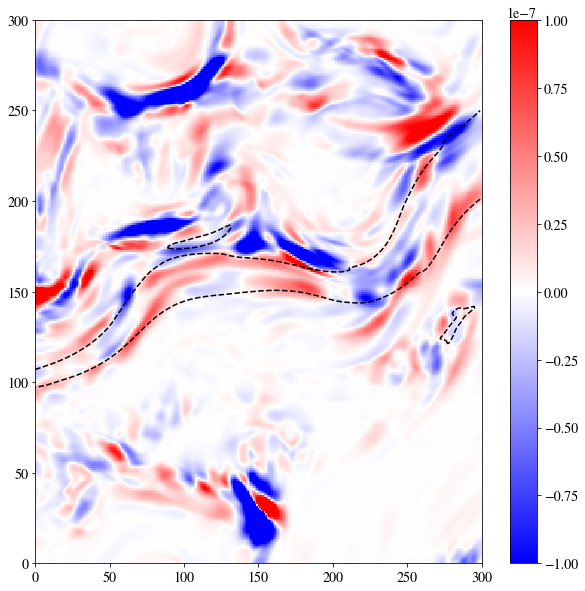

In [43]:
# Can I just subtract the scale fluxes
ts = 10
yl = slice(1000, 3000)
xl = slice(0, 1000)

yl = slice(1700, 2000)
xl = slice(400, 700)
plt.figure(figsize=(10,10))
plt.pcolor((PI_WC-PI_NC).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), vmin=-1e-7, vmax=1e-7, cmap='bwr')
plt.colorbar()
#plt.contour(dsWC.temp.isel(s_rho=-1,ocean_time=ts, eta_rho=yl, xi_rho=xl ))
#plt.contour(dsWC.EBF.isel(ocean_time=ts, eta_rho=yl, xi_rho=xl ))
plt.rcParams['contour.negative_linestyle'] = 'dashed'

#plt.contour(dsNC.temp.isel(s_rho=-1,ocean_time=ts, eta_rho=yl, xi_rho=xl ), colors='r')
#plt.contour((dsWC.EBFp/dsWC.EBF).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), levels=[-5e-2,   5e-2], colors='black')
plt.contour((dsWC.smag/dsNC.smag-1).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), levels=[-2e-1, 2e-1], colors='black')

/tmp/ipykernel_62873/1177029707.py:7: UserWarning: No contour levels were found within the data range.
  plt.contour((PI_WC-PI_NC).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), levels=[-1e-6, 1e-6])


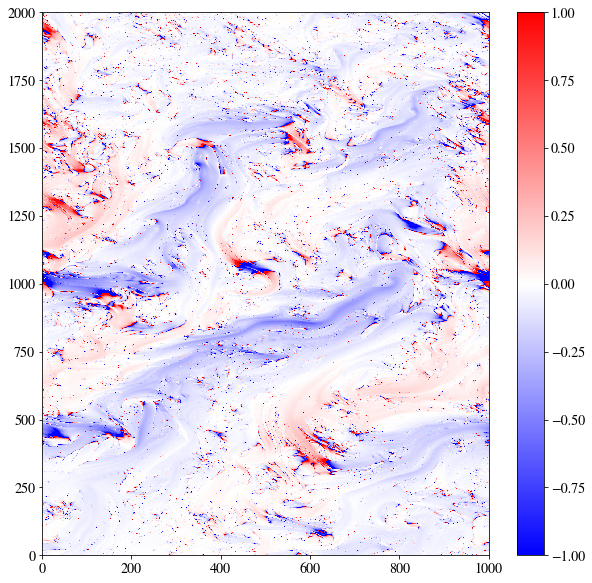

In [29]:
yl = slice(1000, 3000)
xl = slice(0, 1000)

plt.figure(figsize=(10,10))
plt.pcolor((dsWC.EBFp/dsWC.EBF).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), vmin=-1, vmax=1, cmap='bwr')
plt.colorbar()
plt.contour((PI_WC-PI_NC).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), levels=[-1e-6, 1e-6])

#plt.contour((PI_WC-PI_NC).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl))


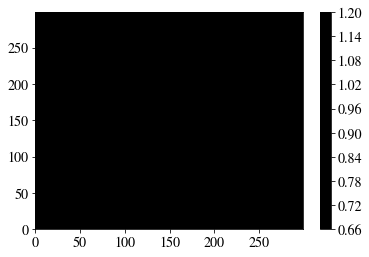

In [34]:
plt.contourf((dsWC.smag/dsNC.smag).isel(ocean_time=ts, eta_rho=yl, xi_rho=xl), colors='black')
plt.colorbar()

# Do the 

In [68]:
ts = 30

scales = [10, 20, 40, 80, 160, 320]

scales = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 150, 200, 250, 300]
scales = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100 ]
scales = [2, 4, 6, 8, 10, 10, 15, 25, 30, 35, 40, 45, 50, 75,  100, 125, 150, 175, 200]
#scales = [5, 20, 100]
PI_WC_SCALES = np.zeros((len(scales),))
PI_NC_SCALES = np.zeros((len(scales),))

counter = 0
for s in scales:
    PI_WC = crossScaleFlux(dsWC.isel(s_rho=-1, ocean_time=ts),gridWC, s) 
    PI_NC = crossScaleFlux(dsNC.isel(s_rho=-1, ocean_time=ts),gridNC, s)
    PI_WC_SCALES[counter] = PI_WC.sum(('eta_rho', 'xi_rho')).compute()
    PI_NC_SCALES[counter] = PI_NC.sum(('eta_rho', 'xi_rho')).compute()
    counter += 1
    print(s)

2
4
6
8
10
10
15
25
30
35
40
45
50
75
100
125
150
175
200


In [ ]:
plt.rcParams['font.size'] = 18

plt.figure(figsize=(10,4))
plt.semilogx(np.array(scales)/2, PI_WC_SCALES/(4002*1002), marker='.', linewidth=2)
plt.plot(np.array(scales)/2, PI_NC_SCALES/(4002*1002), marker='.', linewidth=2, linestyle='--')

plt.ylabel('$\Pi_{cg}$ [m$^2$ s$^{-3}$]')
plt.xlabel('Horizontal length scale, $l$ [km]')
plt.ylim(-1.25e-8, 0.5e-8)
plt.xlim(0, 100)
plt.grid()
plt.title('Kinetic energy flux')
plt.savefig(f'../figures/KE_flux_{ts}.pdf', bbox_inches='tight')

# DO THE WIND STRESS PART

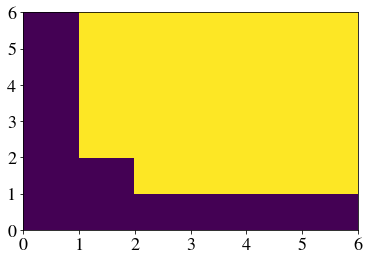

In [ ]:
ww_WC = windWork(dsWC.isel(s_rho=-1), gridWC, 60)
ww_WC
ww_NC = windWork(dsNC.isel(s_rho=-1), gridNC, 60)


In [ ]:
ts = 20

scales = [10, 20, 40, 80, 160, 320, 400, 500, 800, 1000]

#scales = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 75, 100, 150, 200, 250, 300]
#scales = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

WW_WC_SCALES = np.zeros((len(scales),))
WW_NC_SCALES = np.zeros((len(scales),))

counter = 0
for s in scales:
    WW_WC = windWork(dsWC.isel(s_rho=-1, ocean_time=ts),gridWC, s) 
    WW_NC = windWork(dsNC.isel(s_rho=-1, ocean_time=ts),gridNC, s)
    WW_WC_SCALES[counter] = WW_WC.sum(('eta_rho', 'xi_rho')).compute()
    WW_NC_SCALES[counter] = WW_NC.sum(('eta_rho', 'xi_rho')).compute()
    counter += 1
    print(counter)

In [ ]:
plt.plot(np.array(scales)/2, WW_WC_SCALES, marker='.')
plt.plot(np.array(scales)/2, WW_NC_SCALES, marker='.')

plt.grid()

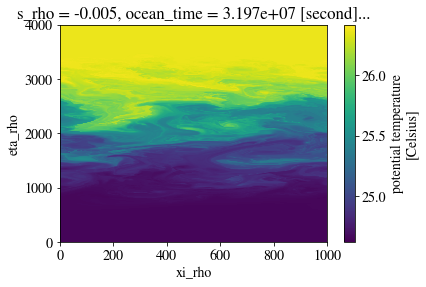

In [45]:
dsWC.rho.isel(ocean_time=10, s_rho=-1).plot()